In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os, glob, random, itertools
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:

# ---------------------------------------------------------
# 1. Paths & constants
# ---------------------------------------------------------
DATASET_DIR = "/content/drive/MyDrive/ChestXRay2017/chest_xray"   # <-- change if needed
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

# ---------------------------------------------------------
# 2. Build a DataFrame of filepaths + clean labels
# ---------------------------------------------------------
def subclass_from_filename(fname: str) -> str:
    """Return 'bacterial', 'viral', or generic 'pneumonia'."""
    lower = fname.lower()
    if "_bacteria" in lower: return "bacterial"
    if "_virus"    in lower: return "viral"
    return "pneumonia"                 # fallback

records = []
for split in ("train", "test"):
    for cls in ("NORMAL", "PNEUMONIA"):
        folder = os.path.join(DATASET_DIR, split, cls)
        for fp in glob.glob(os.path.join(folder, "*.jpeg")):
            label = "normal" if cls == "NORMAL" else subclass_from_filename(fp)
            records.append((fp, label, split))

df = pd.DataFrame(records, columns=["filepath", "label", "split"])
print("Total images:", len(df))
df.head()


Total images: 5876


,filepath,label,split
0,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
1,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
2,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
3,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
4,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train


In [ ]:
# ---------------------------------------------------------
# 3. Create a validation split
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split

train_df = df[df.split=="train"]
train_idx, val_idx = train_test_split(
    train_df.index,
    test_size=0.15,
    stratify=train_df["label"],
    random_state=42)

df.loc[val_idx, "split"] = "val"
print(df["split"].value_counts())


split
train    4464
val       788
test      624
Name: count, dtype: int64


# **Exploratory Data Analysis**

## **Class distribution by split**

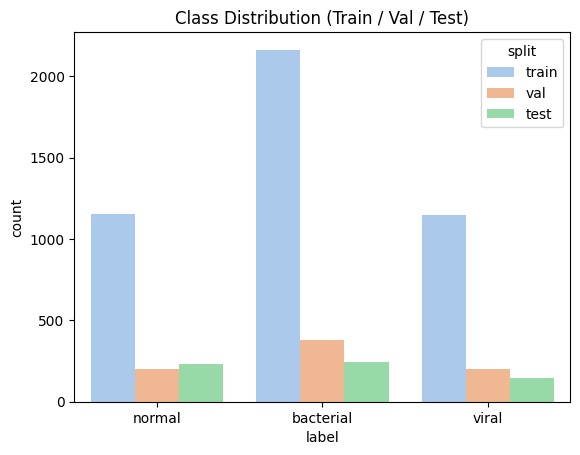

In [ ]:
#   Class distribution by split
sns.countplot(x="label", hue="split", data=df, palette="pastel")
plt.title("Class Distribution (Train / Val / Test)")
plt.show()

## **Random image mosaics for sanity-check**

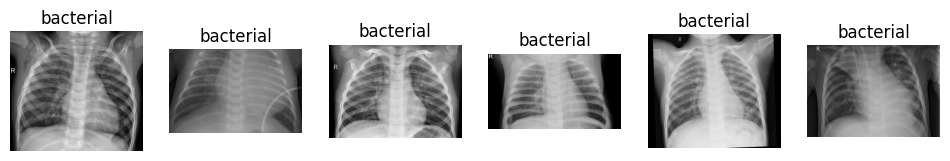

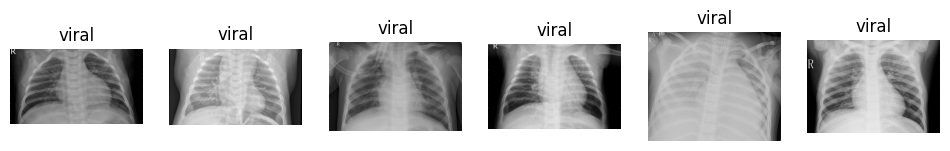

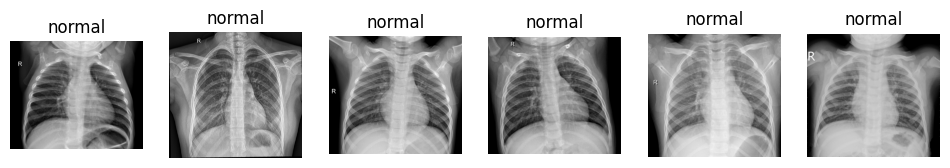

In [ ]:
# Random image mosaics for sanity-check
def show_random_samples(lbl="bacterial", n=6):
    sample_paths = df[(df.label==lbl) & (df.split=="train")]["filepath"].sample(n)
    plt.figure(figsize=(12,2))
    for i, fp in enumerate(sample_paths, 1):
        img = plt.imread(fp)
        plt.subplot(1, n, i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(lbl)
    plt.show()

for lbl in ["bacterial", "viral", "normal"]:
    show_random_samples(lbl)

In [ ]:


#  Image-size statistics
shapes = [tf.image.decode_jpeg(tf.io.read_file(fp), channels=3).shape
          for fp in tqdm(df["filepath"])]
shape_df = pd.DataFrame(shapes, columns=["h","w","c"])
print(shape_df.describe()[["h","w"]])


  0%|          | 0/5876 [00:00<?, ?it/s]

                h            w
count  5876.00000  5876.000000
mean    970.44418  1327.361811
std     383.36124   363.491567
min     127.00000   384.000000
25%     688.00000  1056.000000
50%     887.00000  1280.000000
75%    1187.00000  1560.000000
max    2713.00000  2916.000000


# **Preprocessing**

In [ ]:

# helper: list of filepaths & labels → tf.data.Dataset
label_to_index = {lbl:i for i,lbl in enumerate(sorted(df["label"].unique()))}

def paths_to_dataset(filepaths, labels):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    # -- map strings → image tensors + one-hot labels
    def _load(path, lbl):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0         # [0,1]
        lbl = tf.one_hot(lbl, depth=len(label_to_index))
        return img, lbl
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    return ds

# Gather splits
train_paths = df[df.split=="train"]["filepath"].tolist()
train_labels= df[df.split=="train"]["label"].map(label_to_index).tolist()

val_paths   = df[df.split=="val"]["filepath"].tolist()
val_labels  = df[df.split=="val"]["label"].map(label_to_index).tolist()

test_paths  = df[df.split=="test"]["filepath"].tolist()
test_labels = df[df.split=="test"]["label"].map(label_to_index).tolist()

# Build datasets
train_ds = paths_to_dataset(train_paths, train_labels)\
             .shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds   = paths_to_dataset(val_paths, val_labels)\
             .batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds  = paths_to_dataset(test_paths, test_labels)\
             .batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Dataset shapes →", next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape)


Dataset shapes → (32, 224, 224, 3) (32, 3)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# helper: list of filepaths & labels → tf.data.Dataset
label_to_index = {lbl:i for i,lbl in enumerate(sorted(df["label"].unique()))}

# ----------------------------------------------------------------
# 1. Helper: build model
# ----------------------------------------------------------------
def build_model(num_classes: int, mode: str = "densenet"):
    """mode = 'densenet' for transfer‑learning, 'custom' for small CNN."""
    if mode == "densenet":
        base = tf.keras.applications.DenseNet121(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg")
        base.trainable = False          # phase‑1: feature extractor
        x = tf.keras.layers.Input(shape=(224, 224, 3))
        y = base(x, training=False)
        y = tf.keras.layers.Dropout(0.3)(y)
        y = tf.keras.layers.Dense(num_classes, activation="softmax")(y)
        model = tf.keras.Model(x, y)
    else:  # custom lightweight CNN
        inputs = tf.keras.layers.Input(shape=(224, 224, 3))
        x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
        x = tf.keras.layers.MaxPool2D()(x)
        x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
        x = tf.keras.layers.MaxPool2D()(x)
        x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
        model = tf.keras.Model(inputs, outputs)
    return model

# ----------------------------------------------------------------
# 2. Compile & train
# ----------------------------------------------------------------
num_classes = len(label_to_index)
model_type  = "densenet"   # choose: "densenet" or "custom"
EPOCHS      = 15

model = build_model(num_classes, mode=model_type)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="prec"),
             tf.keras.metrics.Recall(name="rec")])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_"+model_type+".h5", monitor="val_accuracy",
        save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=4, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks)

# ----------------------------------------------------------------
# 3. Fine‑tuning phase (optional for DenseNet)
# ----------------------------------------------------------------
if model_type == "densenet":
    # unfreeze top N layers
    base = model.layers[1]  # DenseNet base
    for layer in base.layers[-30:]:
        layer.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy","auc","precision","recall"])
    fine_hist = model.fit(
        train_ds,
        epochs=5,
        validation_data=val_ds,
        callbacks=callbacks)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4341 - auc: 0.6221 - loss: 1.2254 - prec: 0.4495 - rec: 0.3597
Epoch 1: val_accuracy improved from -inf to 0.49492, saving model to best_densenet.h5


140/140 ━━━━━━━━━━━━━━━━━━━━ 1632s 11s/step - accuracy: 0.4345 - auc: 0.6225 - loss: 1.2247 - prec: 0.4499 - rec: 0.3602 - val_accuracy: 0.4949 - val_auc: 0.6566 - val_loss: 1.2084 - val_prec: 0.5258 - val_rec: 0.4657
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3492 - auc: 0.5018 - loss: 1.5028 - prec: 0.3593 - rec: 0.2744
Epoch 2: val_accuracy improved from 0.49492 to 0.51142, saving model to best_densenet.h5


140/140 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.3502 - auc: 0.5030 - loss: 1.5002 - prec: 0.3604 - rec: 0.2754 - val_accuracy: 0.5114 - val_auc: 0.6933 - val_loss: 1.1024 - val_prec: 0.5503 - val_rec: 0.4721
Epoch 3/15
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4007 - auc: 0.5598 - loss: 1.3530 - prec: 0.4239 - rec: 0.3253
Epoch 3: val_accuracy improved from 0.51142 to 0.51269, saving model to best_densenet.h5


140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 231ms/step - accuracy: 0.4025 - auc: 0.5618 - loss: 1.3488 - prec: 0.4258 - rec: 0.3270 - val_accuracy: 0.5127 - val_auc: 0.7227 - val_loss: 1.0043 - val_prec: 0.5846 - val_rec: 0.4822
Epoch 4/15
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4644 - auc: 0.6202 - loss: 1.2031 - prec: 0.4900 - rec: 0.3768
Epoch 4: val_accuracy improved from 0.51269 to 0.52792, saving model to best_densenet.h5


140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 220ms/step - accuracy: 0.4659 - auc: 0.6220 - loss: 1.1998 - prec: 0.4918 - rec: 0.3785 - val_accuracy: 0.5279 - val_auc: 0.7460 - val_loss: 0.9500 - val_prec: 0.6091 - val_rec: 0.4924
Epoch 5/15
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4995 - auc: 0.6625 - loss: 1.1291 - prec: 0.5253 - rec: 0.4124
Epoch 5: val_accuracy improved from 0.52792 to 0.55076, saving model to best_densenet.h5


140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.5008 - auc: 0.6640 - loss: 1.1262 - prec: 0.5267 - rec: 0.4139 - val_accuracy: 0.5508 - val_auc: 0.7663 - val_loss: 0.9027 - val_prec: 0.6298 - val_rec: 0.4987
Epoch 6/15
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5302 - auc: 0.7048 - loss: 1.0402 - prec: 0.5635 - rec: 0.4471
Epoch 6: val_accuracy improved from 0.55076 to 0.58629, saving model to best_densenet.h5


140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 227ms/step - accuracy: 0.5313 - auc: 0.7060 - loss: 1.0378 - prec: 0.5646 - rec: 0.4484 - val_accuracy: 0.5863 - val_auc: 0.7924 - val_loss: 0.8406 - val_prec: 0.6672 - val_rec: 0.5140
Epoch 7/15
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5669 - auc: 0.7337 - loss: 0.9812 - prec: 0.5958 - rec: 0.4742

In [ ]:
#


# ----------------------------------------------------------------
# 4. Evaluation on test set
# ----------------------------------------------------------------
test_metrics = model.evaluate(test_ds, verbose=0)
print("\nTest metrics:", dict(zip(model.metrics_names, test_metrics)))

# Predictions → classification report & confusion matrix
y_true = np.concatenate([y for _,y in test_ds])
y_pred_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_cls = np.argmax(y_true, axis=1)

target_names = [k for k,_ in sorted(label_to_index.items(), key=lambda kv: kv[1])]
print("\nClassification report:")
print(classification_report(y_true_cls, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true_cls, y_pred)
print("Confusion Matrix:\n", cm)

# ROC‑AUC (macro, one‑vs‑rest)
if num_classes == 2:
    auc_score = roc_auc_score(y_true_cls, y_pred_prob[:,1])
else:
    auc_score = roc_auc_score(y_true, y_pred_prob, multi_class="ovr", average="macro")
print("Macro ROC‑AUC:", auc_score)

# ----------------------------------------------------------------
# 5. Plot training curves
# ----------------------------------------------------------------
def plot_history(hist_dict, title):
    plt.figure(figsize=(6,4))
    for label, series in hist_dict.items():
        plt.plot(series, label=label)
    plt.xlabel("Epoch")
    plt.title(title)
    plt.legend()
    plt.show()

plot_history({"train_acc": history.history["accuracy"],
              "val_acc": history.history["val_accuracy"]},
             "Accuracy vs Epoch")

plot_history({"train_loss": history.history["loss"],
              "val_loss": history.history["val_loss"]},
             "Loss vs Epoch")

NameError: name 'label_to_index' is not defined